# import

In [92]:
import sys
# '/opt/intel/openvino_2019.2.242/python/python3.7' doesn't work 
# sys.path[1] = '/opt/intel/openvino_2019.2.242/python/python3.6'

from openvino.inference_engine import IENetwork, IEPlugin, IECore

import requests
from PIL import Image
from io import BytesIO
import cv2
import numpy as np
import os
import math
import matplotlib.pyplot as plt

import logging as log
import time

from vinopy.detector.detector import Detector
from vinopy.model.model_detect import *
from vinopy.util.config import TASKS

In [2]:
def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA)
    return new_image


In [3]:
def imshow(image):
    image = pil2cv(image)
    cv2.imshow("image", image)
    cv2.waitKey(0) #何かしらのキーが押されるまで待つ
    cv2.destroyAllWindows() #すべてのWindowを破棄

In [4]:
tasks = list(TASKS.keys())
tasks

['detect_face',
 'emotion_recognition',
 'estimate_headpose',
 'detect_body',
 'estimate_humanpose']

In [132]:
#frame = np.asarray(Image.open('./data/test/face.jpg'))
frame = np.asarray(Image.open('./data/test/person2.jpg'))

In [133]:
model = ModelEstimateHumanPose()
model_db = ModelDetectBody()

In [134]:
bboxes = model_db.get_pos(frame)
preds = {}
for bbox_num, bbox in enumerate(bboxes[0][0]):
    xmin, ymin, xmax, ymax = model_db.get_box(bbox, frame)
    bbox_frame = model_db.crop_bbox_frame(frame, xmin, ymin, xmax, ymax)

In [135]:
frame = bbox_frame

In [136]:
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]

In [137]:
out = model.predict(bbox_frame)

In [138]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
               "Background": 15 }

POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
               ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
               ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]


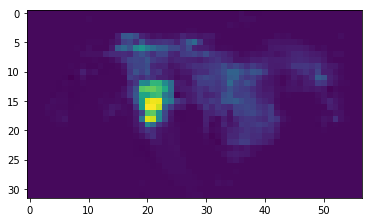

In [139]:
plt.imshow(out[0, 7, :, :])

In [140]:
points = []
for i in range(len(BODY_PARTS)):
    # Slice heatmap of corresponging body's part.
    heatMap = out[0, i, :, :]

    _, conf, _, point = cv2.minMaxLoc(heatMap)
    x = (frameWidth * point[0]) / out.shape[3]
    y = (frameHeight * point[1]) / out.shape[2]

    # Add a point if it's confidence is higher than threshold.
    points.append((int(x), int(y)) if conf > 0.1 else None)


In [141]:
for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

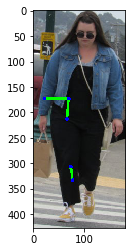

In [142]:
plt.imshow(frame)

In [143]:
t, _ = model.net.getPerfProfile()
freq = cv.getTickFrequency() / 1000
cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

cv2.imshow('OpenPose using OpenCV', frame)


AttributeError: 'openvino.inference_engine.ie_api.IENetwork' object has no attribute 'getPerfProfile'

In [130]:
points

[(449, 325),
 None,
 None,
 None,
 None,
 (131, 325),
 (430, 350),
 (374, 400),
 (430, 575),
 (430, 575),
 None,
 (112, 375),
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [25]:
heatMap

array([[  2.60380366e-05,   2.60380366e-05,   2.60380366e-05, ...,
          2.60380366e-05,   2.60380366e-05,   2.60380366e-05],
       [  2.60380366e-05,   2.60380366e-05,   2.60380366e-05, ...,
          2.60380366e-05,   2.60380366e-05,   2.60380366e-05],
       [  2.60380366e-05,   4.78910551e-05,   2.60380366e-05, ...,
          2.60380366e-05,   2.60380366e-05,   2.60380366e-05],
       ..., 
       [  7.73351989e-04,   4.76733781e-04,   5.84597583e-04, ...,
         -9.17720434e-04,  -1.08457229e-03,  -7.09280372e-04],
       [  3.57506186e-04,   2.85467919e-04,   6.59425976e-04, ...,
         -1.83360040e-04,  -1.31855068e-05,   4.94331412e-04],
       [  9.34537384e-05,   5.85834438e-04,   8.73549550e-04, ...,
         -7.56049849e-05,   2.61253535e-05,   6.10142306e-04]], dtype=float32)

In [7]:
model.

In [9]:
import cv2 as cv
import numpy as np

In [10]:
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
inp = cv.dnn.blobFromImage(frame, inScale, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
net.setInput(inp)
out = net.forward()

assert(len(BODY_PARTS) <= out.shape[1])

points = []
for i in range(len(BODY_PARTS)):
    # Slice heatmap of corresponging body's part.
    heatMap = out[0, i, :, :]

    # Originally, we try to find all the local maximums. To simplify a sample
    # we just find a global one. However only a single pose at the same time
    # could be detected this way.
    _, conf, _, point = cv.minMaxLoc(heatMap)
    x = (frameWidth * point[0]) / out.shape[3]
    y = (frameHeight * point[1]) / out.shape[2]

    # Add a point if it's confidence is higher than threshold.
    points.append((int(x), int(y)) if conf > args.thr else None)

for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)

    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]

    if points[idFrom] and points[idTo]:
        cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
        cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
        cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

t, _ = net.getPerfProfile()

NameError: name 'inScale' is not defined

(1155, 1500, 3)
(1155, 1500, 3)



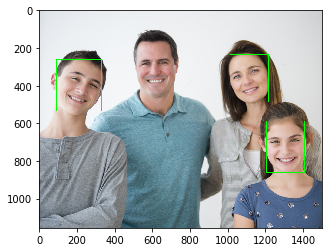

(1155, 1500, 3)
(1155, 1500, 3)



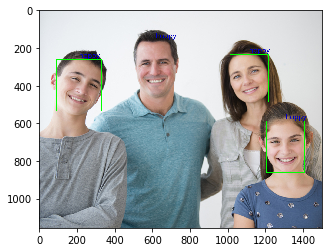

(1155, 1500, 3)
(1155, 1500, 3)



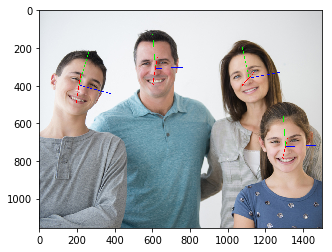

(1155, 1500, 3)
(1155, 1500, 3)



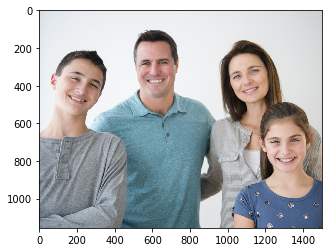

In [12]:
for task in tasks[0:4]:
    img = frame.copy()
    print(img.shape)
    detector = Detector(task)
    img = detector.compute(img)
    
    print(img.shape)
    print()
    plt.imshow(img)
    plt.show()

In [8]:
preds = detector.predict(frame)

In [10]:
preds

array([[[[ 0.        ,  1.        ,  0.9991504 ,  0.66073012,  0.29900444,
           0.79685462,  0.85401285],
         [ 0.        ,  1.        ,  0.99737477,  0.44102976,  0.31126282,
           0.61268079,  0.84036624]]]], dtype=float32)

In [7]:
type(frame)

PIL.JpegImagePlugin.JpegImageFile

In [8]:
frame.format

'JPEG'

In [9]:
type(frame)

PIL.JpegImagePlugin.JpegImageFile

In [10]:
model_db = ModelDetectBody()

NameError: name 'ModelDetectBody' is not defined

# run

In [14]:
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)
while True:
    ret, frame = cap.read()
    
    frame = np.array(frame)

    #######
    
    frame = detector.compute(frame)
    
    #######
    cv2.imshow('demo', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

# image

In [21]:
%matplotlib inline
import requests
from PIL import Image
from io import BytesIO
import cv2
import numpy as np
import os
import sys
import math
from openvino.inference_engine import IENetwork, IEPlugin
import matplotlib.pyplot as plt

from vinopy.detector.detector import Detector

# plot setting
rows = 6
columns = 6
plt.rcParams['figure.figsize'] = (18.0, 18.0)
figsize = (8, 8)
# Read Image
image_url = "https://how-old.net/Images/faces2/main001.jpg"
#image_url = "https://www.soccer-king.jp/wp-content/uploads/2018/03/GettyImages-872455424.jpg"
response = requests.get(image_url)
frame = np.array(Image.open(BytesIO(response.content)))
scale = 640 / frame.shape[1]
frame = cv2.resize(frame, dsize=None, fx=scale, fy=scale)

In [18]:
frame = cv2.imread('data/test/test.jpg')
frame = cv2.resize(frame, dsize=None, fx=scale, fy=scale)

In [22]:
model = Detector('estimate_headpose')

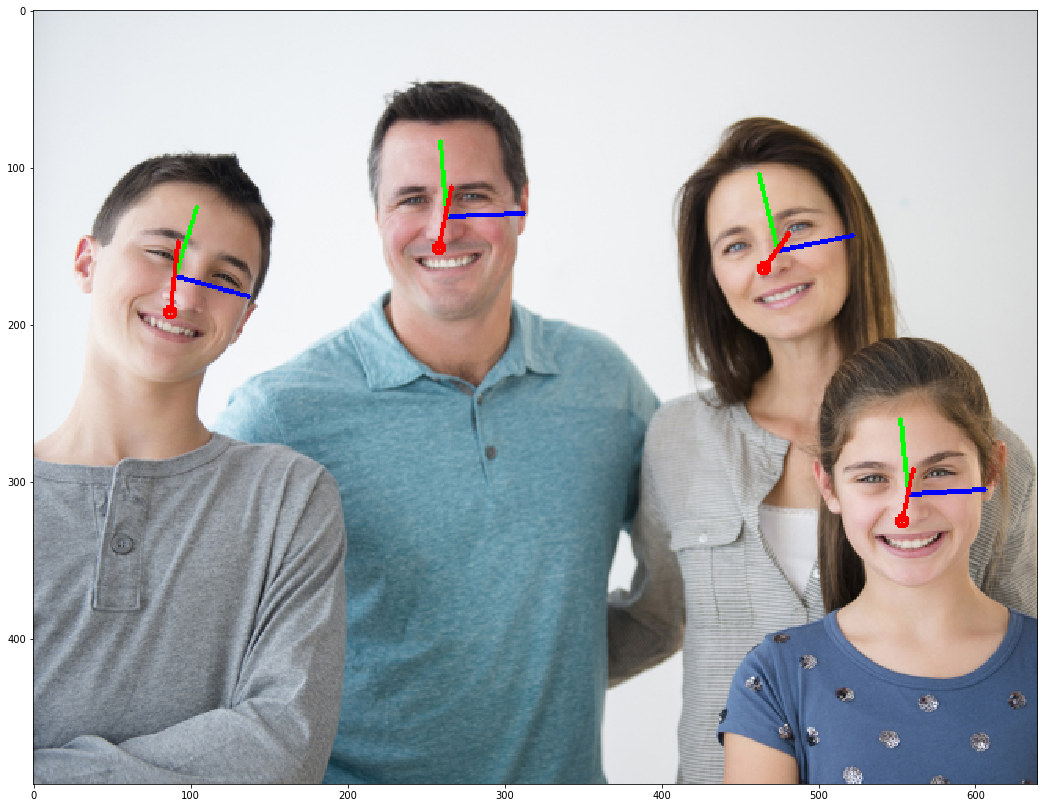

In [23]:
plt.imshow(model.compute(frame))

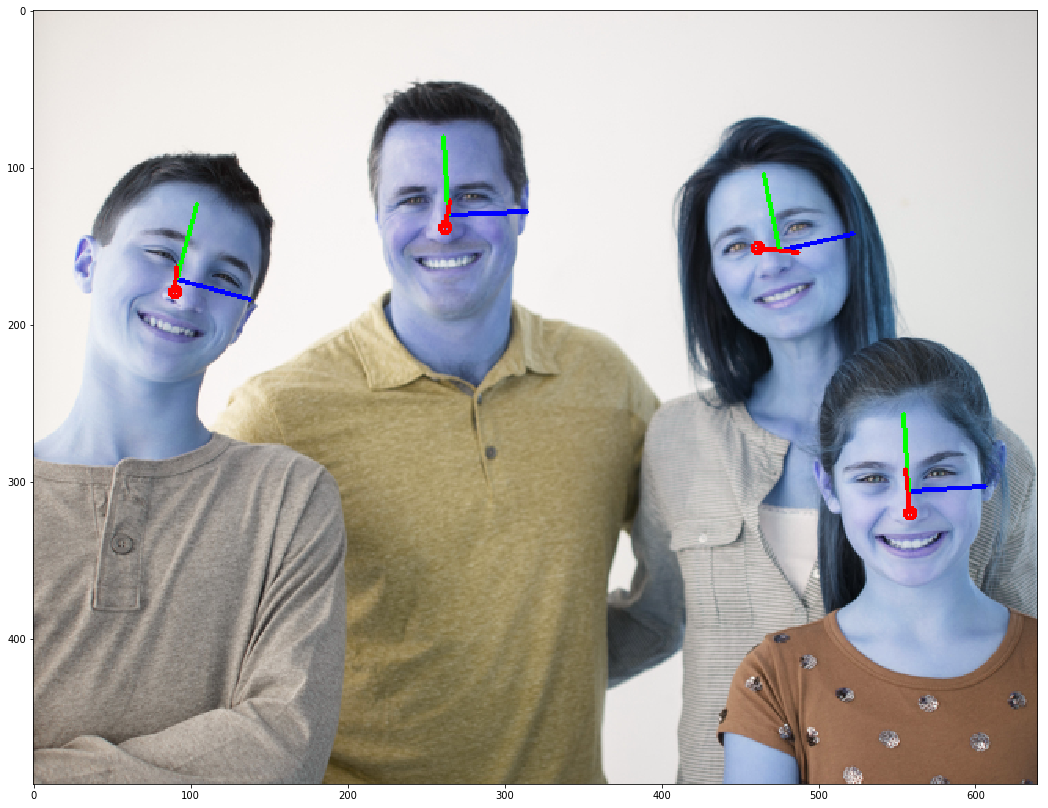

In [20]:
plt.imshow(model.compute(frame))

In [57]:
frame_cv2 = cv2.imread('./data/test/person.jpg')

In [59]:
img_cv2 = model_db.detect_face(frame_cv2)

In [76]:
imshow(img_cv2)

In [31]:
frame_pil = Image.open('./data/test/person2.jpg')
frame_pil = np.asarray(frame_pil)

In [30]:
def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA)
    return new_image


In [32]:
import numpy as np

def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    return new_image

frame_pil = pil2cv(frame_pil)

In [34]:
img_pil = model_db.detect(frame_pil)

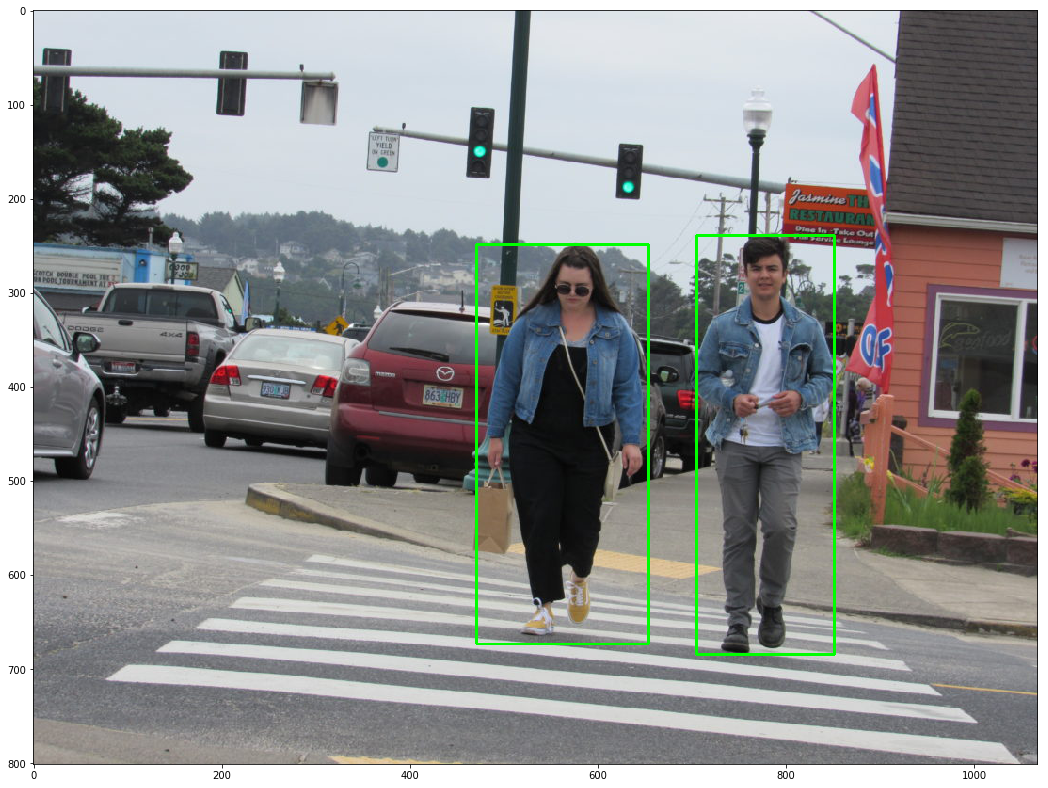

In [35]:
plt.imshow(img_pil)

Original Shape:(1155, 1500)
frame_h, frame_w:(493, 640)


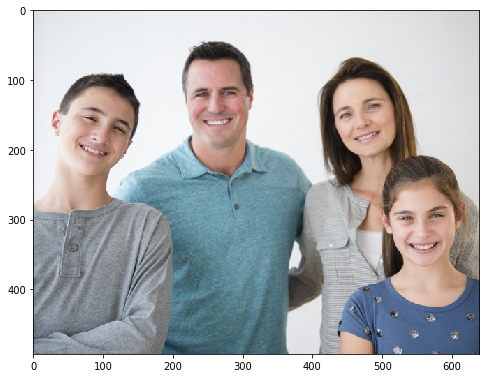

In [16]:
print("Original Shape:{}".format(frame.shape[:2]))

# resize image with keeping frame width
scale = 640 / frame.shape[1]
frame = cv2.resize(frame, dsize=None, fx=scale, fy=scale)
frame_h, frame_w = frame.shape[:2]
init_frame = frame.copy()

print("frame_h, frame_w:{}".format(frame.shape[:2]))
plt.figure(figsize=figsize)
plt.imshow(frame)

# for an image on local store
# OpenCV uses BGR as its default color (matplotlib uses RGB)
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#plt.imshow(face_frame)

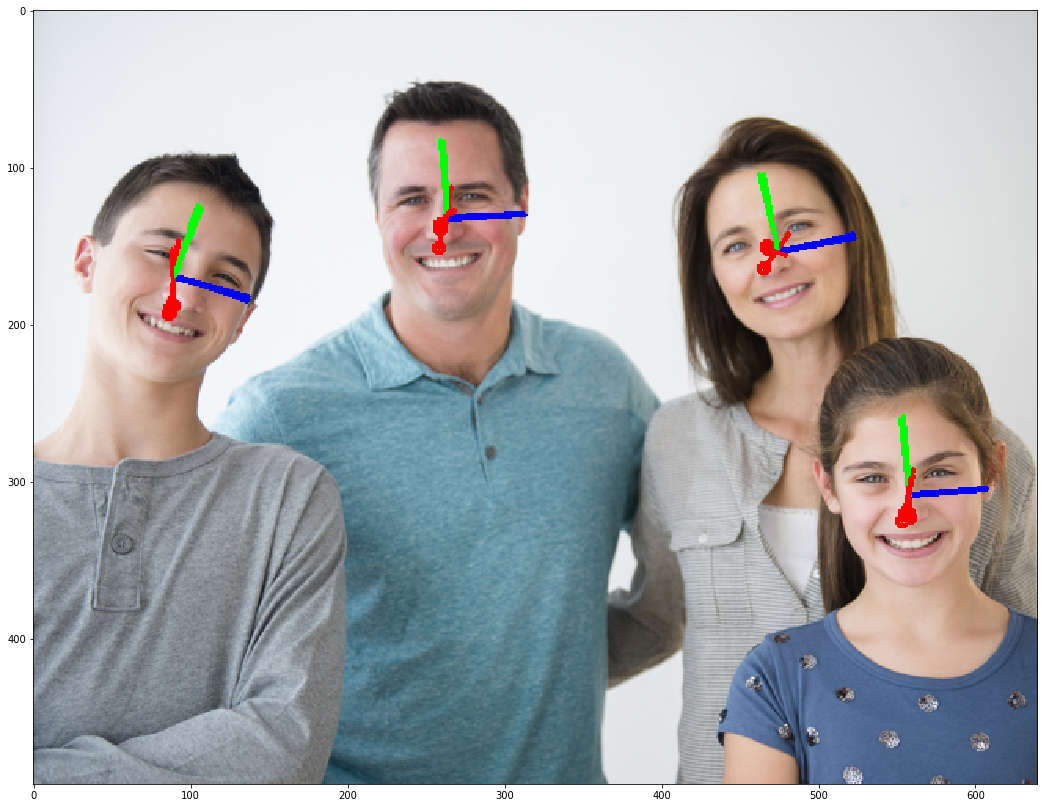

In [20]:
plt.imshow(detector.compute(frame))

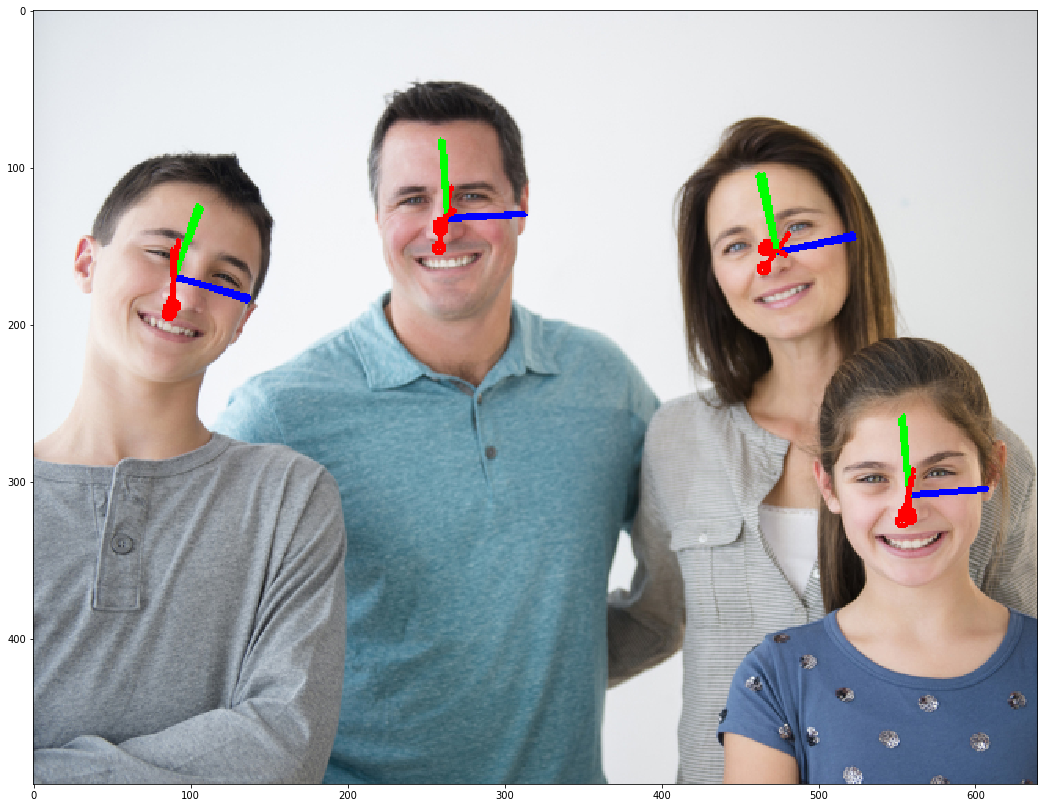

In [21]:
image = detector.compute(frame)
plt.imshow(image)
plt.show()

In [112]:
path_extension = '/opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension.dylib'

input:{'data': <openvino.inference_engine.ie_api.InputInfo object at 0x10c3050c0>}
output:{'detection_out': <openvino.inference_engine.ie_api.OutputInfo object at 0x110a8ba58>}
input.shape:[1, 3, 384, 672]
output.shape:[1, 1, 200, 7]


array([[[[ 0.        ,  1.        ,  0.99999917,  0.8040396 ,  0.50772989,
           0.93906057,  0.74512625],
         [ 0.        ,  1.        ,  0.99999273,  0.67415386,  0.20316961,
           0.81081396,  0.42160091],
         [ 0.        ,  1.        ,  0.99998677,  0.34577927,  0.13760452,
           0.47722587,  0.39774776],
         [ 0.        ,  1.        ,  0.99937373,  0.06222285,  0.2267226 ,
           0.22237313,  0.46430075]]]], dtype=float32)

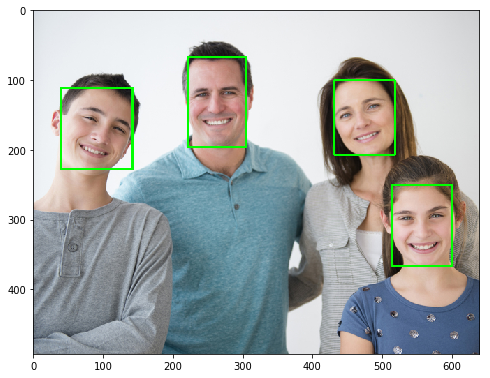

In [113]:
# Face Detection

# 1. Plugin initialization for specified device and load extensions library if specified
device = "CPU"
fp_path = "../extension/IR/FP32/" if device == "CPU" else "../extension/IR/FP16/"
plugin = IEPlugin(device=device, plugin_dirs=None)
if device == "CPU":
    plugin.add_cpu_extension(path_extension)

# 2.Read IR
model_xml = "./intel_models/face-detection-adas-0001.xml"
model_bin = os.path.splitext(model_xml)[0] + ".bin"
net = IENetwork(model=model_xml, weights=model_bin)

# 3. Configure input & output
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))
n, c, h, w = net.inputs[input_blob].shape
print("input:{}\noutput:{}".format(net.inputs,net.outputs))
print("input.shape:{}\noutput.shape:{}".format(
    net.inputs[input_blob].shape, net.outputs[out_blob].shape))

# 4. Load Model
exec_net = plugin.load(network=net, num_requests=2)

# 5. Create Async Request
in_frame = cv2.resize(frame, (w, h))
in_frame = in_frame.transpose((2, 0, 1))
in_frame = in_frame.reshape((n, c, h, w))
exec_net.start_async(request_id=0, inputs={input_blob: in_frame}) # res's shape: [1, 1, 200, 7]

# 6. Receive Async Request
if exec_net.requests[0].wait(-1) == 0:
    res = exec_net.requests[0].outputs[out_blob]
    faces = res[0][:, np.where(res[0][0][:, 2] > 0.5)] # prob threshold : 0.5

# 7. draw faces
frame = init_frame.copy()
for face in faces[0][0]:
    box = face[3:7] * np.array([frame_w, frame_h, frame_w, frame_h])
    (xmin, ymin, xmax, ymax) = box.astype("int")
    """
    xmin = int(face[3] * frame_w)
    ymin = int(face[4] * frame_h)
    xmax = int(face[5] * frame_w)
    ymax = int(face[6] * frame_h)
    """
    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
plt.figure(figsize=figsize)
plt.imshow(frame)
faces

input:{'data': <openvino.inference_engine.ie_api.InputInfo object at 0x1102f7db0>}
output:{'prob_emotion': <openvino.inference_engine.ie_api.OutputInfo object at 0x110a9c9f0>}
input.shape:[1, 3, 64, 64]
output.shape:[1, 5, 1, 1]


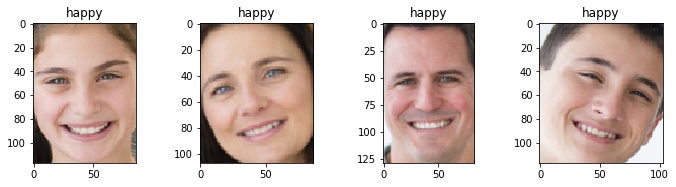

In [114]:
# Emotion Recognition
label = ('neutral', 'happy', 'sad', 'surprise', 'anger')

# 1.Read IR
model_xml = "./intel_models/emotions-recognition-retail-0003.xml"
model_bin = os.path.splitext(model_xml)[0] + ".bin"
net = IENetwork(model=model_xml, weights=model_bin)

# 2. Configure input & putput
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))
n, c, h, w = net.inputs[input_blob].shape
print("input:{}\noutput:{}".format(net.inputs,net.outputs))
print("input.shape:{}\noutput.shape:{}".format(
    net.inputs[input_blob].shape, net.outputs[out_blob].shape))

# 3. Load Model
exec_net = plugin.load(network=net, num_requests=2)

# 4. Create Async Request
frame = init_frame.copy()
face_id = 0
for face in faces[0][0]:
    box = face[3:7] * np.array([frame_w, frame_h, frame_w, frame_h])
    (xmin, ymin, xmax, ymax) = box.astype("int")
    face_frame = frame[ymin:ymax, xmin:xmax]
    in_frame = cv2.resize(face_frame, (w, h))
    in_frame = in_frame.transpose((2, 0, 1))
    in_frame = in_frame.reshape((n, c, h, w))
    exec_net.start_async(request_id=0 ,inputs={input_blob: in_frame})
    
    # 5. Get reponse
    if exec_net.requests[0].wait(-1) == 0:
        res = exec_net.requests[0].outputs[out_blob]
        emotion = label[np.argmax(res[0])]
        ax = plt.subplot(rows, columns, face_id + 1)
        ax.set_title("{}".format(emotion))
        plt.imshow(face_frame)
        face_id +=1

In [119]:
faces[0][0][0]

array([ 0.        ,  1.        ,  0.99999917,  0.8040396 ,  0.50772989,
        0.93906057,  0.74512625], dtype=float32)

In [115]:
emotion

'happy'